<a href="https://colab.research.google.com/github/Davdesigner/Mission_capstone/blob/main/David_Mission_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ModelNotebook: Rice Quality Assessment Using Computer Vision
##Environment Setup & Data Loading

In [13]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

##Dataset Importation

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [21]:
import glob
import os
import zipfile

dataset_path = "/content/drive/MyDrive/Mission Capstone/Dataset"
trained = "/content/drive/MyDrive/Mission Capstone/Dataset/Train.csv"
tested = "/content/drive/MyDrive/Mission Capstone/Dataset/Test.csv"



Final IMG_DIR set to: /content/drive/MyDrive/Mission Capstone/Dataset/images
extract_path set to: /content/drive/MyDrive/Mission Capstone/Dataset/extracted_dataset

--- Listing contents of dataset_path ---
['SampleSubmission.csv', 'Train.csv', 'Test.csv', 'DataDictionary.csv', 'manifest-475add6ee315506beb52ddf7f0ce714120251222-19663-1vnbtvd.json', 'images', 'extracted_dataset']

--- Listing contents of extract_path ---
[]

--- Listing contents of IMG_DIR: /content/drive/MyDrive/Mission Capstone/Dataset/images ---
['ID_D10EC7.png', 'ID_674BFC.png', 'ID_8B0DC6.png', 'ID_3E313B.png', 'ID_4F8765.png', 'ID_0E5566.png', 'ID_A50ABB.png', 'ID_861DC9.png', 'ID_33EBD5.png', 'ID_BCC0D4.png']
... and 165 more items.


##Load Labels

In [4]:
labels = pd.read_csv(trained)
labels.head()


,ID,Comment,Count,Broken_Count,Long_Count,Medium_Count,Black_Count,Chalky_Count,Red_Count,Yellow_Count,Green_Count,WK_Length_Average,WK_Width_Average,WK_LW_Ratio_Average,Average_L,Average_a,Average_b
0,ID_556F39,Paddy,957,261,193,0,895,0,62,0,0,9.28,3.18,3.08,63.00,8.43,31.59
1,ID_AA68C7,White,2009,1022,730,0,124,791,4,9,551,6.34,2.13,3.00,70.36,-2.49,-7.29
2,ID_19CA14,Paddy,1062,302,242,0,1031,0,30,1,0,9.23,3.15,3.03,61.32,8.13,30.52
3,ID_92FB0C,Brown,1098,231,812,0,180,862,11,44,1,7.59,2.57,2.98,66.48,-0.58,12.64
4,ID_EAE27D,Brown,1456,529,758,1,211,1117,16,110,2,7.12,2.31,3.13,65.97,-0.40,10.86


In [5]:
print(labels.columns)


Index(['ID', 'Comment', 'Count', 'Broken_Count', 'Long_Count', 'Medium_Count',
       'Black_Count', 'Chalky_Count', 'Red_Count', 'Yellow_Count',
       'Green_Count', 'WK_Length_Average', 'WK_Width_Average',
       'WK_LW_Ratio_Average', 'Average_L', 'Average_a', 'Average_b'],
      dtype='object')


#2. Data Exploration & Visualization
##  Dataset Overview

In [6]:
print("Total Samples:", len(labels))
labels.describe()


Total Samples: 938


,Count,Broken_Count,Long_Count,Medium_Count,Black_Count,Chalky_Count,Red_Count,Yellow_Count,Green_Count,WK_Length_Average,WK_Width_Average,WK_LW_Ratio_Average,Average_L,Average_a,Average_b
count,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000,938.000000
mean,1373.968017,441.256930,570.512793,1.222814,572.908316,488.843284,18.934968,72.946695,74.431770,7.649606,2.562015,3.067814,64.263689,2.774765,15.414691
std,342.729702,333.284894,298.419337,6.213425,451.839995,467.972276,20.931841,130.477088,165.377135,1.218459,0.375099,0.346505,6.324825,5.424295,14.555197
min,802.000000,58.000000,7.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,4.930000,1.810000,1.810000,28.910000,-5.300000,-10.690000
25%,1131.250000,247.000000,265.000000,0.000000,163.250000,0.000000,3.000000,1.000000,0.000000,6.680000,2.260000,2.860000,60.400000,-1.887500,-0.697500
50%,1302.500000,355.000000,625.500000,0.000000,380.000000,481.000000,13.000000,13.000000,0.000000,7.210000,2.495000,3.050000,64.475000,0.050000,13.625000
75%,1532.750000,506.750000,818.000000,1.000000,1038.000000,868.000000,27.000000,68.750000,34.250000,8.997500,2.870000,3.270000,68.757500,8.027500,30.480000
max,3621.000000,3117.000000,1308.000000,114.000000,1764.000000,2602.000000,146.000000,992.000000,845.000000,10.210000,3.790000,4.130000,81.760000,21.400000,42.370000


## Image Loading & Preprocessing

In [17]:
# IMG_DIR is now set dynamically in cell 'iZIxhmsv6Ynm'
IMG_SIZE = 224

def load_image(img_name):
    img_path = os.path.join(IMG_DIR, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img / 255.0


In [29]:
image_col = 'ID'
target_columns = ['Count'] # Assuming 'Count' corresponds to 'Grain_Count' from subsequent cells

# Get a list of all actual image filenames in IMG_DIR (without extension)
existing_image_files = set([f.replace('.png', '') for f in os.listdir(IMG_DIR) if f.endswith('.png')])

# Filter the labels DataFrame to only include entries where the image file exists
labels_filtered = labels[labels[image_col].isin(existing_image_files)].copy()

# Create a 'filename' column with the full image filenames (ID + .png extension)
labels_filtered['filename'] = labels_filtered[image_col] + '.png'

print(f"Original labels count: {len(labels)}")
print(f"Filtered labels count (images found): {len(labels_filtered)}")

# Prepend the image ID with the .png extension to match actual image filenames
X = np.array([load_image(img_id + '.png') for img_id in labels_filtered[image_col]])
y = labels_filtered[target_columns].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Original labels count: 938
Filtered labels count (images found): 119


##Sample Images Visualization

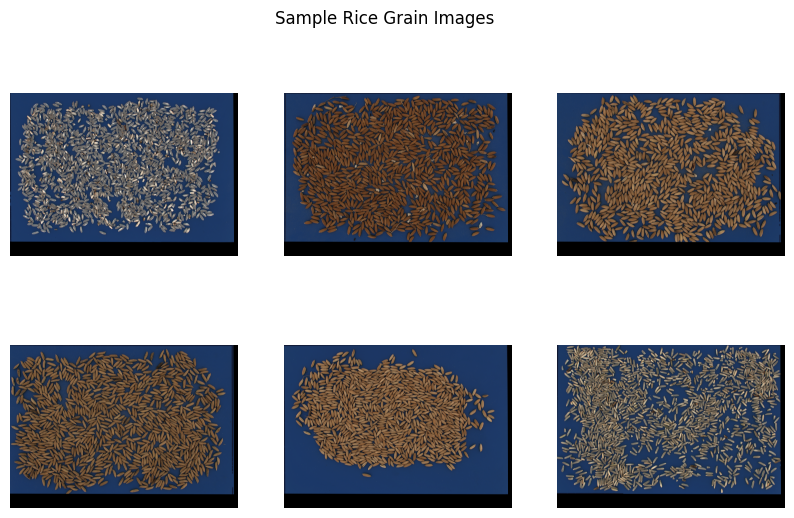

In [24]:
from PIL import Image

sample_paths = labels_filtered['ID'].sample(6)
plt.figure(figsize=(10,6))

for i, ID in enumerate(sample_paths):
    img = Image.open(os.path.join(IMG_DIR, ID + '.png'))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Sample Rice Grain Images")
plt.show()


##Distribution of Grain Counts

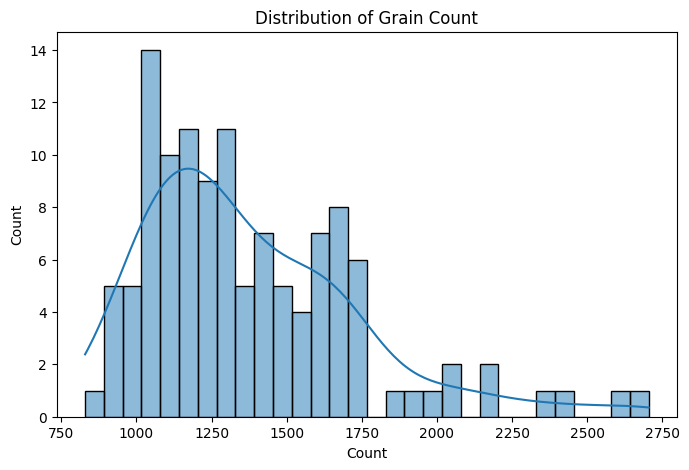

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(labels_filtered['Count'], bins=30, kde=True)
plt.title("Distribution of Grain Count")
plt.show()

##Correlation Heatmap

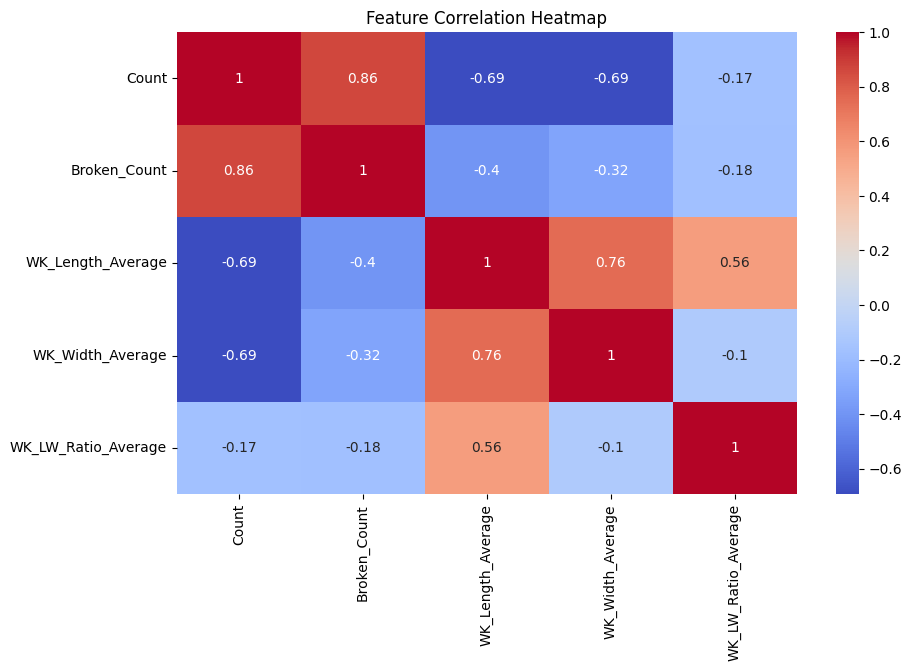

In [26]:
features = ['Count','Broken_Count','WK_Length_Average',
            'WK_Width_Average','WK_LW_Ratio_Average']

plt.figure(figsize=(10,6))
sns.heatmap(labels[features].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

#3. Data Engineering
## Image Preprocessing & Augmentation

In [27]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2
)

## Train–Validation Split

In [30]:
train_gen = datagen.flow_from_dataframe(
    labels_filtered,
    directory=IMG_DIR,
    x_col="filename", # Use the new 'filename' column
    y_col="Count",
    target_size=(224,224),
    batch_size=32,
    class_mode="raw",
    subset="training"
)

val_gen = datagen.flow_from_dataframe(
    labels_filtered,
    directory=IMG_DIR,
    x_col="filename", # Use the new 'filename' column
    y_col="Count",
    target_size=(224,224),
    batch_size=32,
    class_mode="raw",
    subset="validation"
)

Found 96 validated image filenames.
Found 23 validated image filenames.


#4. Model Architecture
##Transfer Learning with MobileNetV2

In [31]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##Custom Regression Head

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="linear")(x)

model = Model(inputs=base_model.input, outputs=output)

##Compile Model

In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#5. Initial Performance Metrics
##Model Training

In [34]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 13s/step - loss: 2095895.7500 - mae: 1392.5391 - val_loss: 2092476.3750 - val_mae: 1415.5328
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - loss: 2083386.7500 - mae: 1387.5387 - val_loss: 2089705.7500 - val_mae: 1414.5721
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 2151845.5000 - mae: 1409.2520 - val_loss: 2086868.7500 - val_mae: 1413.5500
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 2084871.5000 - mae: 1390.8354 - val_loss: 2084673.3750 - val_mae: 1412.7633
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 10s/step - loss: 2032295.2500 - mae: 1378.4807 - val_loss: 2081927.0000 - val_mae: 1411.7853
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - loss: 2047717.3750 - mae: 1377.2908 - val_loss: 2079188.8750 - val_mae: 1410.8551
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - loss: 2077180.2500 - mae: 1388.5745 - val_loss: 2076668.5000 - val_mae: 1409.9587
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - loss: 2093293.1250 -

##Loss Curve

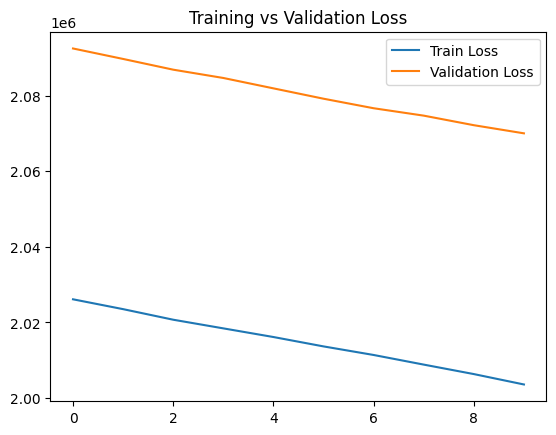

In [35]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


##Evaluation Metrics

In [36]:
val_preds = model.predict(val_gen)
mae = mean_absolute_error(val_gen.labels, val_preds)
rmse = np.sqrt(mean_squared_error(val_gen.labels, val_preds))

print("MAE:", mae)
print("RMSE:", rmse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
MAE: 1407.3115234375
RMSE: 1438.3863354467742


##Deployment